<a href="https://colab.research.google.com/github/sflyranger/Neural_networks_projects/blob/main/dense_embeddings_slack_posts_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'orange'>**Multi-label Classification: Dense Embeddings**

#### <font color = 'orange'>*Using a multi layered perceptron for training*

##<font color = 'orange'>**Setting up the environment**

In [ ]:
    import sys
    if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
        # mount google drive
        from google.colab import drive
        drive.mount('/content/drive')
        # set the base path to a Google Drive folder
        base_path = '/content/drive/MyDrive/Colab Notebooks'
        # Installing the latest torchinfo library
        !pip install torchinfo -qq
        !pip install torchmetrics -qq

        sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom-functions')# enabling custom function usage

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 28.1 MB/s eta 0:00:00


In [ ]:
# libraries for efficient serialization of python objects and for element tallying
from collections import Counter
import joblib

# filesystem libraries, generating and displaying confusion matrices, binarization for one-hot labels, data splitting, and date-time manipulations
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# custom dataset making from torch
from torch.utils.data import Dataset
# utility for gradient clipping
from torch.nn.utils import clip_grad_value_


# library to compute class weights
from sklearn.utils.class_weight import compute_class_weight

# general purpose libraries
import pandas as pd
import numpy as np
import random

# for working with textual data vocabularies and for displaying model summaries
from torchinfo import summary

# library for tensor computations and neural network modules
import torch
import torch.nn as nn

# libraries for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# printing library for formatted output of text
from pprint import pprint

# library for conversion of strings
import ast

# HammingDistance is useful for evaluating multi-label classification problems.
from torchmetrics import HammingDistance

# library for iterations within rows
from itertools import combinations

# importing functools for partial function usage in freezing
from functools import partial




In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Appending the data set path
base_folder = Path(base_path)
data_folder = base_folder/'datasets/stack_posts_ds'
model_folder = base_folder/'models/nlp_fall_2024/stack'

In [ ]:
# ensuring the model_folder is created in my drive
model_folder.mkdir(parents = True, exist_ok =True)

## <font color = 'orange'>**Loading the dataset**</font>

- This data set is a kaggle competition data set where the goal of the competition was to classify different questions from StackExchange users for different tech domains.
- Each post could mention multiple tech domains, hence why this model will be a multi-label classification task.
- The goal here will be to use a dense embedding layer within my NN to classify and understand the difference between dense and sparse embeddings for classification and their benefits.
- Overall, the layers within the entire model will consist of the following within a Simple Multi Layer Perceptron:
  - **Embedding Bag layer**
  - **Linear Layer 1**
  - **Hidden layer 1**
  - **ReLu**
  - **Dropout layer 1**
  - **BatchNorm layer 1**
  - **Linear Layer 2**
  - **Hidden Layer 2**
  - **ReLu**
  - **Dropout Layer 2**
  - **BatchNorm Layer 2**
  - **Output layer**

- The hyperparameters that will be used to fine-tune the model are as follows:
  - **Neurons for the first hidden layer**: 200
  - **Neurons for the second hidden layer**: 100
  - **Embedding Dimension**: 300
  - **EPOCHS**: 5
  - **BATCH_SIZE**: 128
  - **LEARNING_RATE**: 0.001
  - **WEIGHT_DECAY**: 0.000
  - **CLIP_TYPE**: 'value'
  - **PATIENCE**: 5
  - **Optimizer**: AdamW

- I will also be doing some gradient clipping and using the **Hamming Loss** as a metric, which I defined in other notebooks.



In [ ]:
# location of our slack data set
stack_file = data_folder/'stack_posts_ds.joblib'

# loading the data in via the stack file
stack_df = joblib.load(stack_file)

print(stack_df.head())
print(stack_df.dtypes)
print('Data shape:', stack_df.shape)

                                        cleaned_text               Tags  \
0  asp query stre dropdown webpage follow control...         c# asp.net   
1  run javascript code server java code want run ...    java javascript   
2  linq sql throw exception row find change hi li...         c# asp.net   
3  run python script php server run nginx web ser...         php python   
4  advice write function m try write function res...  javascript jquery   

  Tag_Number  
0     [0, 9]  
1     [1, 3]  
2     [0, 9]  
3     [2, 7]  
4     [3, 5]  
cleaned_text    object
Tags            object
Tag_Number      object
dtype: object
Data shape: (47427, 3)


## <font color = 'orange'>**Data Observations**</font>
- We have three columns in the file:
  - **cleaned_text**: contains the preprocessed posts in object format.
  - **Tags**: contains the label name of the actual tags.
  - **Tag Number**: contains our target classification labels for the given posts.
  - The coordinating tags for each of the given tech domains are as follows:
    - **0**: c#
    - **1**: java
    - **2**: php
    - **3**: javascript
    - **4**: android
    - **5**: jquery
    - **6**: c++
    - **7**: python
    - **8**: iphone
    - **9**: asp.net

- A problem I am noticing is that the tag_number element list is in object format, we need to convert it to integers.





In [ ]:
# Function to convert list elements to integers, skipping None or empty lists
def convert_list_to_int(tag_list):
    if tag_list is None or len(tag_list) == 0:
        return []  # Return an empty list if None or empty
    return [int(x) for x in tag_list if x is not None]  # Skip None values

# Apply the function to each row in the 'Tag_Number' column
stack_df['Tag_Number'] = stack_df['Tag_Number'].apply(lambda x: convert_list_to_int(x if isinstance(x, list) else ast.literal_eval(str(x))))


In [ ]:
stack_df['Tag_Number'].head()

,Tag_Number
0,"[0, 9]"
1,"[1, 3]"
2,"[0, 9]"
3,"[2, 7]"
4,"[3, 5]"


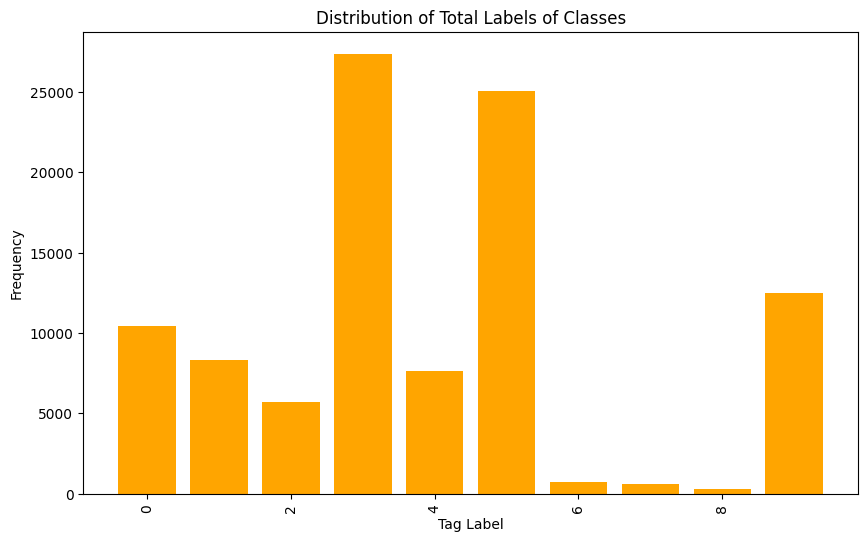

In [ ]:
# Flatten the lists for counting
all_tags = [tag for sublist in stack_df['Tag_Number'] for tag in sublist]

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Plotting the visual representation
plt.figure(figsize=(10,6))
plt.bar(tag_counts.keys(), tag_counts.values(), color='orange')
plt.title('Distribution of Total Labels of Classes')
plt.xlabel('Tag Label')
plt.ylabel('Frequency')

# Rotate x-tick labels for better readability if needed
plt.xticks(rotation=90)

plt.show()

<span style="color: orange;">**The above plot shows the label distributions. It is important to note that this is not grouped by posts, as each post can have more than one label. Instead, it represents the distribution of labels in total. It seems like we have some class imbalance within our labels.**</span>


### <font color='orange'>**One Hot Encoding the Tags**</font>

- Below, we will use the `MultiLabelBinarizer` from `sklearn` to one-hot encode our tags.


In [ ]:
# Setting the binarizer
mlb = MultiLabelBinarizer()

# transforming the tag numbers
one_hot_encoded_tags = mlb.fit_transform(stack_df['Tag_Number'])

# making a df and labeling based on the mlb stored classes

ohe_tags_df = pd.DataFrame(one_hot_encoded_tags, columns = mlb.classes)

# concatenating the dataframe to the original stack_df
stack_df = pd.concat([stack_df, ohe_tags_df], axis = 1)

#check to ensure the encoding is done
stack_df.columns


Index(['cleaned_text', 'Tags', 'Tag_Number', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')

###<font color = 'orange'>**Data Split**

- split here will be done with 60% training, 20% for test, and the remaining 20% for validation.


In [ ]:
# Defining filepath for training data set
train_clean_file = data_folder/'train_clean.pkl'

# filepath for cleaned validation data
valid_clean_file = data_folder/'valid_clean.pkl'

# filepath for the testin data set
test_clean_file = data_folder/'test_clean.pkl'


In [ ]:
# Creating feature text as X
X = stack_df['cleaned_text']

# Setting the target columns, (only the encoded columns)
y = stack_df.drop(columns = ['cleaned_text','Tag_Number', 'Tags'])

# Splitting into train_val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size =0.2, random_state = 42)

# Splitting train_val into val and train
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.2, random_state = 42)

# Dumping the files to drive for later use if necessary
joblib.dump((X_train, y_train), train_clean_file)

joblib.dump((X_val, y_val), valid_clean_file)

joblib.dump((X_test, y_test), test_clean_file)

In [ ]:
print(len(X))
print(len(y))

47427
47427


In [ ]:
print(f"X_train size: {len(X_train)}, y_train size: {len(y_train)}")
print(f"X_val size: {len(X_val)}, y_val size: {len(y_val)}")
print(f"X_test size: {len(X_test)}, y_test size: {len(y_test)}")


X_train size: 30352, y_train size: 30352
X_val size: 7589, y_val size: 7589
X_test size: 9486, y_test size: 9486


In [ ]:
# Reloading the different splits
X_train, y_train = joblib.load(train_clean_file)

X_val, y_val = joblib.load(valid_clean_file)

X_test, y_test = joblib.load(test_clean_file)

In [ ]:
X_test.head()

,cleaned_text
39124,fadein fadeout div checkbox select unselect tr...
29807,php output mvc good day work mvc webpage c m...
6340,compare part byte determine byte cursor adapte...
24876,well way structure new keyword time ago come f...
18035,loop json object array element try create loop...


In [ ]:
X_val.head()

,cleaned_text
32515,click checkbox click surround td table column ...
11737,dynamically change text base input field dynam...
47176,div float try chat option user want chat certa...
44434,will jquery form resubmit time work reason for...
41899,instal application list icon list android try ...


In [ ]:
y_test.head()

,0,1,2,3,4,5,6,7,8,9
39124,0,0,0,1,0,1,0,0,0,0
29807,0,0,1,0,0,0,0,0,0,1
6340,0,1,0,0,1,0,0,0,0,0
24876,0,1,0,0,0,0,1,0,0,0
18035,0,0,0,1,0,1,0,0,0,0


In [ ]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9
38601,0,1,0,0,1,0,0,0,0,0
47089,0,0,0,1,0,1,0,0,0,0
9397,0,0,0,1,0,1,0,0,0,0
46311,1,0,0,0,0,0,0,0,0,1
22026,1,0,0,0,0,0,0,0,0,1


In [ ]:
y_val.head()

,0,1,2,3,4,5,6,7,8,9
32515,0,0,0,1,0,1,0,0,0,0
11737,0,0,1,0,0,1,0,0,0,0
47176,0,0,0,1,0,1,0,0,0,0
44434,0,0,1,1,0,1,0,0,0,0
41899,0,1,0,0,1,0,0,0,0,0


## <font color = 'orange'>**Checking the value counts of the training data set to apply weights to handle class imbalance.**

In [ ]:
# summing across all rows to get the number of occurances
class_counts = np.sum(y_train, axis = 0)

total_samples = y_train.shape[0] # first index value is the number of samples

class_weights = total_samples/(len(class_counts)*class_counts)

class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(class_counts)
print(total_samples)
print(class_weights)

0     6682
1     5321
2     3701
3    17541
4     4875
5    16010
6      479
7      351
8      192
9     7963
dtype: int64
30352
tensor([ 0.4542,  0.5704,  0.8201,  0.1730,  0.6226,  0.1896,  6.3365,  8.6473,
        15.8083,  0.3812])


<font color = 'orange'>**Note:**</font> The class weights above will be plugged into the Binary Cross Entropy Loss Function to ensure better balancing of classes during training.

In [ ]:
y_train.shape


(30352, 10)

In [ ]:
X_train.shape

(30352,)

In [ ]:
# Converting the features and targets to np.array for input to Custom Dataset
X_test = np.array(X_test)
X_train = np.array(X_train)
X_val = np.array(X_val)

y_test = np.array(y_test)
y_train = np.array(y_train)
y_val = np.array(y_val)

# <font color = 'orange'>**Defining a class for a custom dataset**

In [ ]:
class CustomDataset(Dataset):
    """
    A custom class that handles features and one-hot encoded labels

    Attributes:
        X (array-like): The feature data, can be lists or NumPy arrays
        y (array-like): The one-hot encoded target labels
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (array-like): The feature data (can be lists or NumPy arrays).
            y (array-like): The one-hot encoded target labels.
        """
        self.X = X
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Add this check
        assert len(self.X) == len(self.y), "Mismatch between features (X) and labels (y) lengths."

        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample

In [ ]:
# creating the different instances of of the CustomDataset class for modeling
trainset = CustomDataset(X_train, y_train)

validset = CustomDataset(X_val, y_val)

testset = CustomDataset(X_test, y_test)



### <font color = 'orange'>**Printing out one of the samples**

In [ ]:
pprint(trainset[5]) #pulling the whole touple
print()
sixth_sample_text = trainset[5][1] # pulling just the text
pprint(sixth_sample_text)
type(sixth_sample_text)

(array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0]),
 'jquery scroll text hover element want scroll leave hover remove character '
 'append end string continuously fire scroll function mouse enter element > '
 'scroll fire mouse leave element user click html < href="foo.htm '
 'class="scrollthis">this text scroll hover</a >   jquery $ '
 '.scrollthis").hover(function      scroll($(this     function '
 'scroll(ele       var s = $ '
 'ele).text().substr(1)+$(ele).text().substr(0,1      $ ele).text(s  ')

('jquery scroll text hover element want scroll leave hover remove character '
 'append end string continuously fire scroll function mouse enter element > '
 'scroll fire mouse leave element user click html < href="foo.htm '
 'class="scrollthis">this text scroll hover</a >   jquery $ '
 '.scrollthis").hover(function      scroll($(this     function '
 'scroll(ele       var s = $ '
 'ele).text().substr(1)+$(ele).text().substr(0,1      $ ele).text(s  ')


str

In [ ]:
sixth_sample_label = trainset[5][0]
pprint(sixth_sample_label) #printing just the label

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0])


# <font color = 'orange'>**Creating the vocab**

The `get_vocab` function is designed to generate a <font color='orange'>**vocabulary**</font> from a given dataset. Here’s a quick breakdown of how it works:

1. **Initializing a Counter:**
   - A `Counter` object is set up to track the <font color='orange'>**frequency**</font> of each <font color='orange'>**token**</font> (word) that shows up in the dataset.

2. **Token Frequency Counting:**
   - The function iterates through the dataset (a list of tuples with labels and texts). For each text, it splits the text into <font color='orange'>**tokens**</font> and updates the counter to keep track of how often each token appears.

3. **Creating the Vocabulary:**
   - Using this counter, a <font color='orange'>**`torchtext.vocab.vocab`**</font> object is created, containing only tokens that meet the <font color='orange'>**minimum frequency**</font> requirement (<font color='orange'>**`min_freq`**</font>).
   - Tokens that appear less frequently than <font color='orange'>**`min_freq`**</font> are filtered out, keeping the vocab lean.

4. **Handling Unknown Words:**
   - The special token <font color='orange'>**`<unk>`**</font> (for unknown words) is added at index 0, so any token that isn’t found in the vocab gets mapped to <font color='orange'>**`<unk>`**</font>.
   - By default, the vocab index for unknown words is set to 0, ensuring everything’s covered when we encounter out-of-vocabulary tokens.

5. **Return Value:**
   - Finally, the function returns the constructed <font color='orange'>**`Vocab`**</font> object, which can then be used to convert tokens into indices, or vice versa.

In short, the <font color='orange'>**`get_vocab`**</font> function automates the process of creating a vocabulary from text data, ensuring that only sufficiently frequent words are included and unknown words are handled efficiently.


Note: I did not write this class

In [ ]:
from collections import Counter, OrderedDict
from typing import Dict, List, Optional, Union

class Vocab:
    def __init__(self, tokens: List[str]) -> None:
        self.itos: List[str] = tokens
        self.stoi: Dict[str, int] = {token: i for i, token in enumerate(tokens)}
        self.default_index: Optional[int] = None

    def __getitem__(self, token: str) -> int:
        if token in self.stoi:
            return self.stoi[token]
        if self.default_index is not None:
            return self.default_index
        raise RuntimeError(f"Token '{token}' not found in vocab")

    def __contains__(self, token: str) -> bool:
        return token in self.stoi

    def __len__(self) -> int:
        return len(self.itos)

    def insert_token(self, token: str, index: int) -> None:
        if index < 0 or index > len(self.itos):
            raise ValueError("Index out of range")
        if token in self.stoi:
            old_index = self.stoi[token]
            if old_index < index:
                self.itos.pop(old_index)
                self.itos.insert(index - 1, token)
            else:
                self.itos.pop(old_index)
                self.itos.insert(index, token)
        else:
            self.itos.insert(index, token)

        self.stoi = {token: i for i, token in enumerate(self.itos)}

    def append_token(self, token: str) -> None:
        if token in self.stoi:
            raise RuntimeError(f"Token '{token}' already exists in the vocab")
        self.insert_token(token, len(self.itos))

    def set_default_index(self, index: Optional[int]) -> None:
        self.default_index = index

    def get_default_index(self) -> Optional[int]:
        return self.default_index

    def lookup_token(self, index: int) -> str:
        if 0 <= index < len(self.itos):
            return self.itos[index]
        raise RuntimeError(f"Index {index} out of range")

    def lookup_tokens(self, indices: List[int]) -> List[str]:
        return [self.lookup_token(index) for index in indices]

    def lookup_indices(self, tokens: List[str]) -> List[int]:
        return [self[token] for token in tokens]

    def get_stoi(self) -> Dict[str, int]:
        return self.stoi.copy()

    def get_itos(self) -> List[str]:
        return self.itos.copy()

    @classmethod
    def vocab(cls, ordered_dict: Union[OrderedDict, Counter], min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True) -> 'Vocab':
        specials = specials or []
        for token in specials:
            ordered_dict.pop(token, None)

        tokens = [token for token, freq in ordered_dict.items() if freq >= min_freq]

        if special_first:
            tokens = specials + tokens
        else:
            tokens = tokens + specials

        return cls(tokens)

In [ ]:
def get_vocab(dataset, min_freq = 1):
  """
  Generate a vocabulary from a dataset.

  Args:
    dataset (list of tuples): Lists of tuples where each tuple contains a label and a text
    min_freq (int): A integer that represents the minimum number of documents a token can be in to be included in the vocabulary.

  Returns:
    torch.text.vocab.Vocab: Vocabulary Object.
  """
  # Initializing the counter object to hold token frequencies
  counter = Counter()

  # updating the counter with the tokens from each text in the dataset
  for (label, text) in dataset:
    counter.update(text.split())

  # creating the vocabulary using the counter object
  #tokens that appear fewer times than 'min_freq are excluded'
  my_vocab = Vocab.vocab(counter, min_freq = min_freq)

  # inserting the <unk> token for index 0 to represent any unknown words.
  my_vocab.insert_token('<unk>',0)

  # Setting the default index to 0
  my_vocab.set_default_index(0)

  return my_vocab



## <font color = 'orange'>**Importance of fitting the vocab only on the Training set:**

When training a text-based model, it is **extremely important** to remember not to train the vocabulary on the test or validation dataset.

- The reason for this is to prevent any **information leakage** from the training set into the validation or test sets.
- Keeping the training of the vocab only on the **train set** ensures that the model is based on **real-world instances** and improves generalization to **unseen data**.
- This practice also promotes **consistency** when evaluating the model and helps in improving **model fairness**.


In [ ]:
stack_vocab = get_vocab(trainset, min_freq = 2)

In [ ]:
len(stack_vocab)

96934

#### <font color = 'orange'>**Calling the get_itos function pulls out only the string values in the given indexes**

In [ ]:
stack_vocab.get_itos()[0:5] # getting the first five words from the vocab

['<unk>', 'nullpointerexception', 'run', 'figure', 'return']

In [ ]:
# Quick check to ensure unknowns are registering
stack_vocab['cheezeits']

0

#<font color = 'orange'>**Creating the Collate Function for Data Loaders**

- in the DataLoader class of PyTorch, the collate function is used to combine individual samples into batches during data loading. This function is applied after data retrieval and before batching.
- Collate batch takes a list of individual samples (each one represented as a tuple of tensors) and collate them into a single batch. This involves:
  - stacking tensors along a new batch dimension
  - other operations like padding sequences to ensure uniform tensor length

In [ ]:
# function used to get the indices of the words from the vocab
def tokenizer(x, vocab): # x is the given sample, vocab is the pretrained vocab on the training ds
  """
  Converts a list of words into indices using a given vocabulary of mapped indices
  """
  return [vocab[token] for token in x.split()] # splits the sample and returns the index, here, token is actually the index.

In [ ]:
# Quick Example of tokenizer function
print(tokenizer('scroll text hover', stack_vocab) )

print("The above output is the index values of the given words from the example sentence in a list.")

[278, 274, 279]
The above output is the index values of the given words from the example sentence in a list.


The `collate_batch_embedding_bag(batch, my_vocab)` function is responsible for collating a batch of samples from `CustomDatasets` into tensors of **labels**, **texts**, and **offsets**.

- **Unpacking the Batch**:
  - The batch is unpacked using `zip(*batch)` to separate it into two lists: one for the <font color='orange'>**`labels`**</font> and the other for the <font color='orange'>**`texts`**</font>.

- **Converting Labels**:
  - The list of <font color='orange'>**`labels`**</font> is immediately converted into a <font color='orange'>**PyTorch tensor**</font> with the data type set to <font color='orange'>**`torch.float32`**</font>.

- **Tokenizing Texts**:
  - For each text in <font color='orange'>**`texts`**</font>, the **`tokenizer`** function is called to convert the text into a list of <font color='orange'>**vocabulary indices**</font> using the provided vocabulary (<font color='orange'>**`my_vocab`**</font>). The resulting lists are stored in **`list_of_list_of_indices`**.

- **Concatenating Indices**:
  - The individual lists of tokenized indices are concatenated into one large **PyTorch tensor** using **`torch.cat`**. This tensor contains the token indices for all texts in the batch.

- **Calculating Offsets**:
  - To track the boundaries of each text within the concatenated indices, the **`offsets`** tensor is calculated. This tensor starts with **zero** and is followed by the **cumulative sum** of the lengths of each text's token list.

- **Returning Tensors**:
  - Finally, the tensors for <font color='orange'>**`labels`**</font>, <font color='orange'>**`indices`**</font>, and <font color='orange'>**`offsets`**</font> are returned, providing the necessary inputs for the **Embedding Bag** layer.

This process ensures that the batch of text data is correctly prepared for further processing within the neural network, handling varying text lengths while maintaining alignment between the tokenized texts and their respective labels.




In [ ]:
def collate_batch_embedding_bag(batch, my_vocab): # takes in the batches and the vocab
  """
  Collates a batch of samples from the CustomDatasets into tensors of labels, text, and offsets.

  Parameters:
    batch(list): A list of tuples (samples), containing a label and text.

  Returns:
  tuple: A tuple containing two tensors, one for the labels, one for the texts.

  """

  # unpacking the batch into labels and text
  labels, texts = zip(*batch)

  # converting the list of labels into a tensor of dtype float32
  labels = torch.tensor(np.array(labels), dtype =torch.float32)

  # Converting the texts within the batch into tensors with index labels from the vocab
  list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

  # Concattenating the indices from each text onto one another into one tensor
  indices = torch.cat([torch.tensor(i,dtype = torch.int64) for i in list_of_list_of_indices])

  # Calculating the offset values to know where each text ends within the long indices tensor
  offsets = [0] +[len(i) for i in list_of_list_of_indices]

  # Ensuring the offsets are stored as a tensor
  offsets = torch.tensor(offsets[:-1]).cumsum(dim = 0)

  return (indices, offsets), labels


### <font color='orange'>**Checking our collation function using the `partial` function**</font>

- The **`partial` function** allows us to "freeze" certain arguments within a function, setting them in advance.
- This is important because **DataLoader** expects the **collate function** to take only the batch as input. However, our **`collate_batch_embedding_bag`** function also requires the **vocab** as an additional argument. (see above)
- By using the `partial` function, we can pre-set the **vocab** in our **collate_batch_embedding_bag** function, ensuring that when the DataLoader calls the function, it only needs to pass the **batch**. This simplifies how we handle additional arguments like the vocab within the DataLoader.


In [ ]:
batch_size = 2
collate_partial = partial(collate_batch_embedding_bag, my_vocab = stack_vocab) #Freezes the my_vocab argument for the collate_batch_embedding_bag function
check_loader = torch.utils.data.DataLoader(dataset = trainset,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           collate_fn = collate_partial) # passes the collate_fn with a preset vocab list using the given batch size.

In [ ]:
# Testing to see how the DataLoader will pass a sample
torch.manual_seed(22)
for (indices, offset), label in check_loader:
    print(f'Indices:{indices}', f'Offset:{offset}', f'Label:{label}')
    break

Indices:tensor([  167, 26747,  1069,   102,   270,   167, 26747,   466,  6167,   167,
          514,   402,   402,    12, 26747,   428,   655,   177,   180,   604,
         4255,   601,  1904,   604,   229,   449,   649,     6,   466,   180,
        20852,   708,  1538,  1633,    95,  2806,   467,  1053,   467,  1053,
          272,  1505,   253,  1012,   425,  1053,  1069,   274,   466,   200,
        67589,   185,   200, 67590,   136, 67591, 67592,   136, 67593, 67594,
          136,   242,   613,  5310,  1053,   425, 67595, 67596,   613,   263,
          200, 67597,   185, 67595, 67596,   613,   408]) Offset:tensor([ 0, 35]) Label:tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]])


### <font color='orange'>**Understanding the Collate Function Output**</font>

- The first tensor is the list of **indices** referencing the vocabulary of the training dataset. Each word within this batch of text is represented by its corresponding index in the vocabulary. Since the batch size is two, this tensor contains the words from both documents, concatenated into a single, long tensor.
  - For example, the first document starts with the vocab index **`167`**, and subsequent indices represent other tokens in the document. The second document starts at index 35 within the concatenated tensor, indicated by the offset tensor.

- The second tensor, the **offsets**, marks the starting point of each document within the concatenated indices tensor.
  - In this case, the offset tensor is **`[0, 35]`**, meaning the first document starts at index 0 in the indices tensor, and the second document starts at index 35.

- The third tensor represents the **labels**, which are the actual target indicators for the given set of texts (i.e., the type of Stack Exchange post).
  - In this case, both documents in the batch have labels: **`[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]`**, indicating that each document is associated with the labels `javascript` and `jquery`.


# <font color='orange'>**Baseline Model Class**</font>

- The class below represents a **<font color='orange'>Simple MultiLayer Perceptron (MLP)</font>**, a **<font color='orange'>feed-forward neural network</font>** with three layers. This serves as a foundational model that can be used as a starting point for building more complex architectures. After each layer, we apply **<font color='orange'>ReLU</font>**, **<font color='orange'>Batch Normalization</font>**, and **<font color='orange'>Dropout</font>**, making it flexible for training on various tasks.
  - **<font color='orange'>ReLU</font>** introduces non-linearity to the model by zeroing out negative values.
  - **<font color='orange'>Dropout</font>** is used to introduce noise into the model by randomly dropping neurons during each pass, which helps prevent overfitting.
  - **<font color='orange'>Batch Normalization</font>** normalizes the inputs to each layer by standardizing them. This helps control issues like the **<font color='orange'>exploding or vanishing gradient</font>**, improving model stability during training.

- The class is built on PyTorch’s **<font color='orange'>`nn.Module`</font>**, which provides built-in methods to manage and track layers, parameters like **<font color='orange'>weights</font>**, and **<font color='orange'>biases</font>**. It gives us the flexibility to expand this baseline into more sophisticated models.

- In the **<font color='orange'>`__init__` function</font>**, the layers are defined, including **<font color='orange'>trainable layers</font>** like **<font color='orange'>`nn.Linear`</font>** and **<font color='orange'>`nn.Embedding`</font>**. Non-trainable layers like **<font color='orange'>ReLU</font>** and **<font color='orange'>Dropout</font>** are handled directly in the **forward method** to maintain a clean, modular design.

- The **<font color='orange'>forward method</font>** takes in a tuple (containing both **<font color='orange'>indices</font>** and **<font color='orange'>offsets</font>**) and processes them through the layers, making this class highly customizable for text-based tasks.
  - One of the reasons for building this custom model (instead of relying on something like **<font color='orange'>`nn.Sequential`</font>**) is because we need to use the **<font color='orange'>EmbeddingBag</font>** layer, which takes two inputs (the **<font color='orange'>indices</font>** and **<font color='orange'>offsets</font>**). This wouldn’t be possible using `nn.Sequential` since it only handles one input.

- **<font color='orange'>EmbeddingBag</font>** is especially useful for handling variable-length text sequences, as it sums the word embeddings for each document based on the provided **<font color='orange'>indices</font>** and **<font color='orange'>offsets</font>**. This baseline class can be further expanded by integrating additional components or replacing layers for more complex tasks.








In [ ]:
class SimpleMLP(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2,num_outputs):
    super().__init__() # sets this as an init to inherit properties of the nn.Module __init__ function

    # Calling an EmbeddingBag_layer -> Linear_layer -> Hidden_layer->ReLu->BatchNorm->Dropout->Linear_2->Hidden_layer->ReLu->BatchNorm->Dropout->Linear
    # It is important also to note that the Hidden Layer is embedded in the nn.Linear calls

    #Embedding Layer
    self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

    # Linear 1
    self.linear1 = nn.Linear(embedding_dim, hidden_dim1)
    # BatchNorm 1 (1d for text data)
    self.batchnorm1 = nn.BatchNorm1d(num_features = hidden_dim1)
    # Dropout 1
    self.dropout1 = nn.Dropout(p = drop_prob1)

    # Linear 2
    self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
    # BatchNorm 2
    self.batchnorm2 = nn.BatchNorm1d(num_features = hidden_dim2)
    # Dropout 2
    self.dropout2 = nn.Dropout(p=drop_prob1)

    # Linear 3
    self.linear3 = nn.Linear(hidden_dim2, num_outputs)


  def forward(self, input_tuple):
    indices, offsets = input_tuple

    # Passing data through the embedding layer
    x.self.embedding_bag(indices,offsets)

    # Passing data through Linear Layer 1
    x = self.linear1(x)
    # Passing through ReLU
    x = nn.ReLU()(x)
    # Passing through BatchNorm
    x = self.batchnorm1(x)
    # Passing through Dropout
    x = self.dropout1(x)


    # Passing through Linear 2
    x = self.linear2(x)
    # Passing through ReLU
    x = nn.ReLU()(x)
    # Passing through Batchnorm 2
    x = self.batchnorm2(x)
    # Passing through Dropout 2
    x = self.dropout2(x)

    # Passing through final linear layer 3
    x = self.linear3(x)


    return x


# <font color='orange'>**CustomBlock class for usage in nn.Sequential Modeling**</font>

- This class gives me the flexibility to call multiple layers using **<font color='orange'>`nn.Sequential`</font>** and integrate those blocks into more complex models.
- Learning how to use these custom blocks within large-scale models improves **readability** and helps **scale models quickly**.
- The block takes **<font color='orange'>`nn.Sequential`</font>** as a layer, which can house multiple layers inside, like the ones I manually coded above. This allows me to efficiently organize and compile my code.
- The class is versatile—it can be **augmented** to include different layers within the custom block, providing even more flexibility when scaling or adjusting the model for various tasks.



In [ ]:
class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(num_features=output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
        )

    def forward(self, x):
        return self.layers(x)

# <font color='orange'>**Custom Multi Layer Perceptron (MLP) Class with Sequential Modeling**</font>

- This class represents a **Custom MLP** where I integrate **<font color='orange'>`nn.Sequential`</font>** to house multiple layers in a streamlined and easy-to-read format.
- The **<font color='orange'>EmbeddingBag layer</font>** is initialized before the sequential blocks, allowing me to handle variable-length input sequences efficiently.
  
- **<font color='orange'>Custom Blocks</font>** are used inside the **`nn.Sequential`** layer to group layers like **ReLU**, **BatchNorm**, and **Dropout** together. This makes the model more readable and modular, which is especially useful when scaling up or adjusting models.

- Each **CustomBlock** takes the input dimension, applies the necessary transformations (like **<font color='orange'>ReLU**, **BatchNorm**, and **Dropout</font>**), and passes it to the next block, ultimately feeding into the final **<font color='orange'>Linear</font>** layer for output.

- **Forward Method**:
  - The forward pass starts by splitting the input tuple into **<font color='orange'>data</font>** and **<font color='orange'>offsets</font>**.
  - It then uses the **EmbeddingBag layer** to get the embedded representation of the input data.
  - Finally, the output of the embedding is passed through the custom **Sequential layers**, which handle all the transformations defined within the blocks.
  - This ends with the final **Linear layer**, producing the output.

- By structuring the model this way, it's much easier to manage complex architectures, while also ensuring that the layers are more organized and scalable for future modifications.


In [ ]:
class CustomMLP(nn.Module):
  def __init__(self,vocab_size,embedding_dim,hidden_dim1,hidden_dim2, drop_prob1,drop_prob2, num_outputs):
    super().__init__()

    # initializing the embedding_bag layer prior to the sequential layers
    self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

    # Defining what a layer is going to be.
    # This layer is a sequential layer that houses multiple layers
    # This is much easier to read and understand.
    # Each custom block houses the input dimension and plugs it into the output by passing it through the CustomBlock where the ReLU,BatchNorm and Dropout layers are housed.
    self.layers = nn.Sequential(
        CustomBlock(embedding_dim, hidden_dim1, drop_prob1),
        CustomBlock(hidden_dim1, hidden_dim2, drop_prob2),
        nn.Linear(hidden_dim2, num_outputs)
    )


  def forward(self, input_tuple):
      # splitting the tuple
      data,offsets = input_tuple

      # Ensure inputs are on the same device as the model
      assert data.device == next(self.parameters()).device, "Data not on the same device as model"
      assert offsets.device == next(self.parameters()).device, "Offsets not on the same device as model"

      # getting the output from the embedding layer
      embed_out = self.embedding_bag(data,offsets)
      # passing the embedding layer into the layers function where all other layers are housed.
      out = self.layers(embed_out)

      return out

### <font color = 'orange'>**Testing the Custom MLP**


In [ ]:
!pip install torchviz
!pip install Ipython

In [ ]:
# Defining my device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Defining the model
model = CustomMLP(vocab_size = 8, embedding_dim = 10, hidden_dim1 = 5, hidden_dim2 = 5, drop_prob1 = 0.5, drop_prob2 = 0.3,num_outputs = 2)

# Pushing the model to the device
model = model.to(device)

# Fake data
data = torch.tensor([1,2,3,4,5,5], dtype = torch.int32).to(device)
offsets = torch.tensor([0,2,4], dtype = torch.int32).to(device)

summary(model, input_data=[(data,offsets)], device = device, depth = 10, verbose = False)


Layer (type:depth-idx)                   Output Shape              Param #
CustomMLP                                [3, 2]                    --
├─EmbeddingBag: 1-1                      [3, 10]                   80
├─Sequential: 1-2                        [3, 2]                    --
│    └─CustomBlock: 2-1                  [3, 5]                    --
│    │    └─Sequential: 3-1              [3, 5]                    --
│    │    │    └─Linear: 4-1             [3, 5]                    55
│    │    │    └─BatchNorm1d: 4-2        [3, 5]                    10
│    │    │    └─ReLU: 4-3               [3, 5]                    --
│    │    │    └─Dropout: 4-4            [3, 5]                    --
│    └─CustomBlock: 2-2                  [3, 5]                    --
│    │    └─Sequential: 3-2              [3, 5]                    --
│    │    │    └─Linear: 4-5             [3, 5]                    30
│    │    │    └─BatchNorm1d: 4-6        [3, 5]                    10
│    │    │    

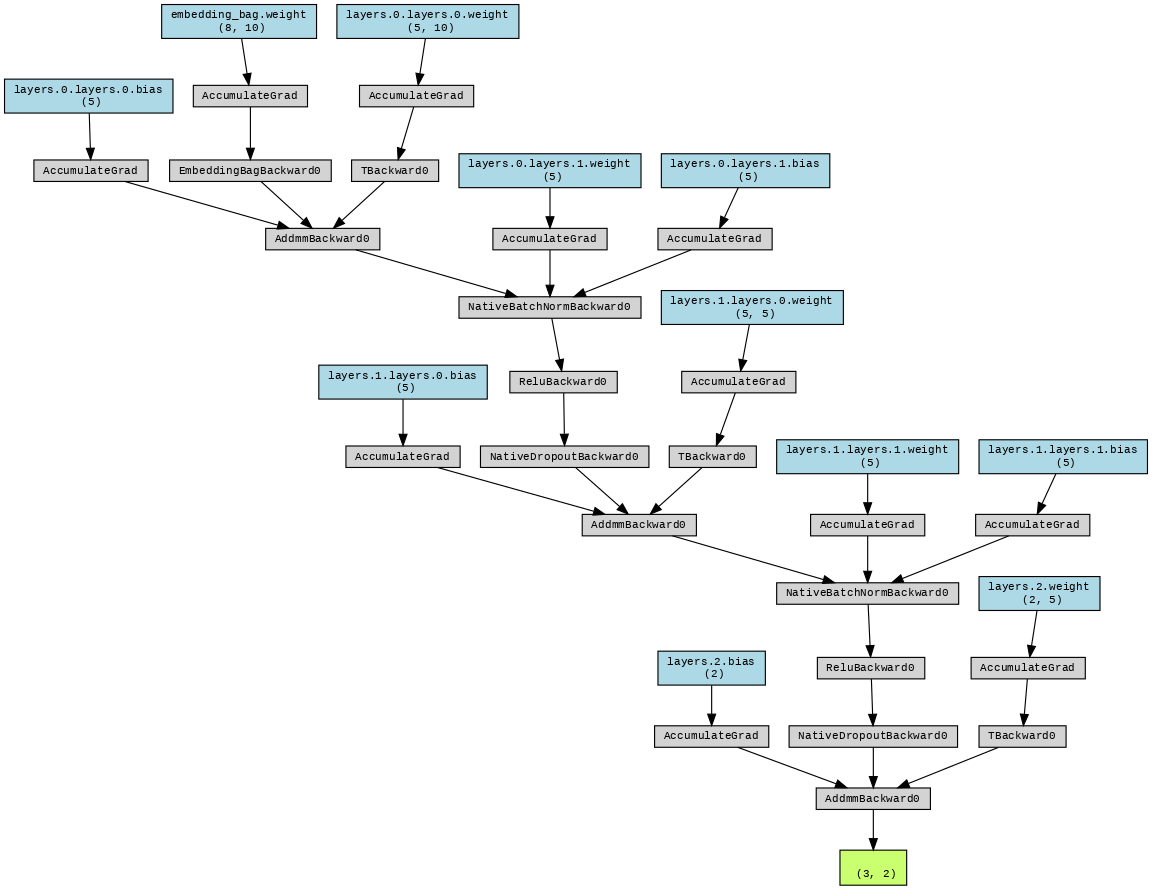

In [ ]:
from torchviz import make_dot
from IPython.display import Image

output = model((data,offsets))

diagram = make_dot(output, params = dict(model.named_parameters()))
diagram.render('CustomMLP_network', format = 'png')

Image(filename ='CustomMLP_network.png')


In [ ]:
print(output)

tensor([[-0.1715, -0.1806],
        [-0.1483, -0.0487],
        [-0.5711, -0.0397]], device='cuda:0', grad_fn=<AddmmBackward0>)


# <font color = 'orange'>**Step function**

In [ ]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):

    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """


    # Move the model and data to the device
    model = model.to(device)

    inputs = tuple(input_tensor.to(device)
                            for input_tensor in inputs)

    targets = targets.to(device).float()

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    predicted = (outputs > 0.5).float()
    # Step 2c: Calculating and updating the hamming distance
    train_hamming_distance = HammingDistance(task = 'multilabel', num_labels = targets.size(1)).to(device)
    hamming_distance = train_hamming_distance(predicted, targets).item()



    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad() # Zero gradients
        loss.backward() # Backward pass
        clip_grad_value_(model.parameters(),clip_value = 10) # Gradient clipping to prevent exploding gradients
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, hamming_distance
    else:
        return None, outputs, hamming_distance

# <font color = 'orange'>**Train_epoch function**
- Step function implemented in the epoch training phase.
- updates the hamming distance and loss for each batch within the epoch.
- takes the average hamming distance and train_loss for that epoch of batches.

In [ ]:
def train_epoch(train_loader, model, device, loss_function,optimizer):
  """
  Trains the model for one epoch using the provided data loader and updates the model parameters.

  Parameters:
  -train_loader (torch.utils.data.DataLoader): dataloader object for the training dataset
  -model (torch.nn.Module): Neural network model to be trained.
  - device (torch.device): The CPU or GPU
  -loss_function: function used to compute the training loss.
  -optimizer: The function to minimize the loss during training by updating model parameters.

  Returns:
  -train_loss (float): Average Training Loss for the epoch.
  -avg_ hamming_distance (float): Training Hamming Distance average for the Epoch.
  """

  # Setting the model to training mode
  model.train()

  # Initializing the variables to track the training loss and correct predictions.
  running_train_loss = 0.0
  running_hamming_distance = 0.0

  # Iterating over all batches
  for inputs, targets in train_loader:
    # Performing the forward and backward pass and updating parameters
    loss,outputs, hamming_distance = step(inputs,targets,model,device,loss_function,optimizer)

    # Updating the running loss and the Hamming Distance
    # adds the training loss from the batch
    running_train_loss += loss.item()
    # adds the hamming distance from the batch
    running_hamming_distance += hamming_distance

  # this calculates the average train loss and hamming distance within the epoch.
  train_loss = running_train_loss/len(train_loader)
  avg_train_hamming_distance = running_hamming_distance / len(train_loader)

  return train_loss, avg_train_hamming_distance

##<font color = 'orange'>**Creating the validate epoch function (val_epoch):**


In [ ]:
def val_epoch(valid_loader,model,device,loss_function):
  """
  Validates the model for one epoch using the provided data loader.


  Parameters:
  - valid_loader (torch.utils.data.DataLoader): Dataloader object for the validation set.
  - model (torch.nn.Module): Neural Network model to be trained
  - device (torch.device): The computing device CPU or GPU.
  - loss_function (torch.nn.Module): Loss function to be used during training.

  Returns:
  - val_loss (float): The validation set loss for the epoch.
  - val_hamming distance (float): Validation Hamming Distance for the epoch.
  """
  # swiching the model to evaluation mode
  model.eval()

  # initiaizing the running validation loss and hamming distance
  running_val_loss = 0.0
  running_hamming_distance = 0.0

  # disabling the gradient to prevent leakage of information and speed up the training process.
  with torch.no_grad():

    # iterating over each batch in the loader.
    for inputs, targets in valid_loader:

      # forward pass for hamming distance:
      loss, outputs, hamming_distance = step(inputs, targets, model, device, loss_function, optimizer = None)

      # Updating the running loss and hamming distance
      running_val_loss += loss.item()
      running_hamming_distance += hamming_distance

  # average validation loss of the epoch
  val_loss = running_val_loss/len(valid_loader)
  # average hamming distance of the epoch
  avg_valid_hamming_distance = running_hamming_distance/len(valid_loader)

  return val_loss, avg_valid_hamming_distance




# <font color='orange'>**Early Stopping Mechanism**</font>

- **Early Stopping** is a regularization technique that helps prevent **overfitting** by monitoring the **validation loss** during training.
- The idea is simple: if the **validation loss** doesn't improve for a set number of epochs (determined by **<font color='orange'>patience</font>**), training will stop early, saving time and preventing the model from overfitting to the training data.
- The **<font color='orange'>`patience`</font>** parameter controls how many epochs we are willing to wait for improvement, and the **<font color='orange'>`delta`</font>** parameter defines the minimum improvement in validation loss required to reset the patience counter.
- This function is essential for ensuring our model generalizes well to unseen data and stops training when no further improvement is observed.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        Initializes the EarlyStopping object to track validation loss and stop training if no improvement.

        Parameters:
        - patience (int): Number of epochs with no improvement after which training will be stopped.
        - delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience          # How many epochs to wait before stopping
        self.delta = delta                # Minimum improvement required
        self.best_loss = float('inf')     # Initialize best loss as infinity
        self.counter = 0                  # Counter for how many epochs since improvement
        self.early_stop = False           # Flag for whether to stop early

    def __call__(self, val_loss):
        """
        Check whether the validation loss has improved sufficiently. If not, increase the counter.
        If the counter reaches the patience, set the early_stop flag to True.

        Parameters:
        - val_loss (float): The current validation loss to be compared against the best loss.
        """
        # If the validation loss improves by more than delta
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss     # Update best loss
            self.counter = 0              # Reset the counter
        else:
            # No improvement, increment the counter
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True     # Set the early stopping flag


## <font color = 'orange'>**Train function for full dataset**


In [ ]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience):
  """
  Trains and validates the model, and returns history of train and validation metrics.

  Parameters:
  - train_loader(torch.utils.data.DataLoader): The defined training dataset loader.
  - valid_loader(torch.utils.data.DataLoader): The defined validation dataset loader.
  - model(torch.nn.Module): The Neural Network we want to train.
  - optimizer (torch.optim.Optimizer): The defined optimizer to update model weights.
  - loss_function (torch.nn.Module): The defined loss function to evaluate the model.
  - epochs: the number of epochs to train the model on the full dataset.
  - device (torch.device): The defined device CPU or GPU

  Returns:
  - train_loss_history (list): History of training loss for each epoch.
  - train_hamming_history (list): History of training hamming distance for each epoch.
  - valid_loss_history (list): History of validation loss for each epoch.
  - valid_hamming_history (list): History of validation hamming distance for each epoch.
    """
  train_loss_history = []
  train_hamming_history = []
  valid_loss_history = []
  valid_hamming_history = []

  # inititializing early stopping
  early_stopping = EarlyStopping(patience = patience)

  # Iterating the train_epoch and val_epoch functions over every epoch
  for epoch in range(epochs):
    train_loss, avg_train_hamming_distance = train_epoch(
        train_loader, model, device, loss_function, optimizer)

    val_loss, avg_valid_hamming_distance = val_epoch(
        valid_loader, model, device, loss_function
    )

    # appending the losses and hamming distances to the histories
    train_loss_history.append(train_loss)
    train_hamming_history.append(avg_train_hamming_distance)
    valid_loss_history.append(val_loss)
    valid_hamming_history.append(avg_valid_hamming_distance)

    # epoch level summaries
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'Train loss:{train_loss:.4f} | Train Hamming Distance: {avg_train_hamming_distance}')
    print(f'Validation loss: {val_loss:.4f} | Validation Hamming Distance:{avg_valid_hamming_distance}')
    print()


  return train_loss_history, train_hamming_history, valid_loss_history, valid_hamming_history


# <font color = 'orange'>**Training the Model**

## <font color = 'orange'>**Hyperparameters**
- The hyperparameters that will be used to fine-tune the model are as follows:
  - **Neurons for the first hidden layer**: 200
  - **Neurons for the second hidden layer**: 100
  - **Embedding Dimension**: 300
  - **EPOCHS**: 5
  - **BATCH_SIZE**: 128
  - **LEARNING_RATE**: 0.001
  - **WEIGHT_DECAY**: 0.000
  - **CLIP_TYPE**: 'value'
  - **PATIENCE**: 5
  - **Optimizer**: AdamW

In [ ]:
# model parameters
EMBED_DIM=300
VOCAB_SIZE=len(stack_vocab)
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=10
PATIENCE= 5


# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.000

## <font color = 'orange'>**Training Configurations**

In [ ]:
# Fixing the seed values for reproducibility
SEED = 1717
random.seed(SEED)                           # Sets the seed for the random module
np.random.seed(SEED)                        # Sets the seed for the np.random module for number generation
torch.manual_seed(SEED)                     # Sets the seed for PyTorch CPU
torch.cuda.manual_seed(SEED)                 # Sets the seed for the PyTorch GPU
torch.backends.cudnn.deterministic = True   # Ensures the deterministic behavior in CuDNN

# Defining the device for model training (Cuda T4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Defining the collate function with a fixed vocabulary using 'partial'
collate_fn = partial(collate_batch_embedding_bag, my_vocab = stack_vocab)

# Data Loaders for the train, valid and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True,
                                           collate_fn = collate_fn, num_workers = 0) # num_workers allows for cpu cores to handle some processing while the model trains on the GPU

valid_loader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True,
                                           collate_fn = collate_fn, num_workers = 0)

test_loader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True,
                                          collate_fn = collate_fn, num_workers = 0)
# Move class weights to the correct device
class_weights = class_weights.to(device)

# defining the loss function and applying class weights
loss_function = nn.BCEWithLogitsLoss(pos_weight = class_weights)

# Defining the model with the parameters
model_stack = CustomMLP(vocab_size = VOCAB_SIZE,
                        embedding_dim = EMBED_DIM,
                        hidden_dim1 = HIDDEN_DIM1,
                        hidden_dim2 = HIDDEN_DIM2,
                        drop_prob1 = DROP_PROB1,
                        drop_prob2 = DROP_PROB2,
                        num_outputs = NUM_OUTPUTS)

# initializing the optimizer to train the model
optimizer = torch.optim.AdamW(model_stack.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

# Make sure the model is on the correct device
model_stack = model_stack.to(device)


### <font color = 'orange'>**Checkpoints**

In [ ]:
print(f"Model device: {next(model_stack.parameters()).device}")
print(f"Inputs device: {[input_tensor.device for input_tensor in inputs]}")
print(f"Targets device: {targets.device}")

Model device: cuda:0
Inputs device: [device(type='cpu'), device(type='cpu')]
Targets device: cuda:0


In [ ]:
print(f"Output shape: {output.shape}")
print(f"Targets shape: {targets.shape}")


Output shape: torch.Size([128, 10])
Targets shape: torch.Size([128, 10])


In [ ]:
# Check if there are NaNs in the outputs or targets
print(torch.isnan(output).any())  # Should print False
print(torch.isnan(targets).any())  # Should print False


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [ ]:
# Check for any non-binary values in the targets
print(torch.unique(targets))


tensor([0., 1.], device='cuda:0')


## <font color='orange'>**Sanity Check for Multi-Label Classification**</font>

Before diving into full-scale training, it's always a good idea to run a **sanity check**. This quick check ensures that both the data processing and the model's forward pass are working as expected. For our multi-label classification setup, we can compare the actual loss from an untrained model to the **theoretical loss** for random predictions.

- Since we're using **`BCEWithLogitsLoss`**, which combines the sigmoid function and binary cross-entropy, the expected **theoretical loss** for random predictions should be close to **`log(2)`** (around 0.693). This is because a random guess for each label would yield about a 50% probability for being either 0 or 1.

- The process here involves running a single forward pass on a batch of data and computing the loss without any gradients. If the actual loss from the untrained model is close to **`log(2)`**, it suggests that our model architecture and data processing are set up correctly, and we’re ready to move forward.

This step helps catch any potential issues early on, so we don’t waste time training a model that has fundamental errors in its setup.


In [ ]:
# Running the DataLoader for the first batch to inspect the data
for inputs, targets in train_loader:
    # Unpack the inputs (indices and offsets)
    indices, offsets = inputs

    # Print the shape and device of indices and offsets
    print(f"indices shape: {indices.shape}, indices device: {indices.device}")
    print(f"offsets shape: {offsets.shape}, offsets device: {offsets.device}")

    # Print the shape and device of targets (labels)
    print(f"targets shape: {targets.shape}, targets device: {targets.device}")

    # Move the data to the appropriate device (GPU or CPU)
    indices = indices.to(device)
    offsets = offsets.to(device)
    targets = targets.to(device)

    # Print again after moving to the device
    print(f"indices device after moving: {indices.device}")
    print(f"offsets device after moving: {offsets.device}")
    print(f"targets device after moving: {targets.device}")

    # Ensure all data is on the same device
    assert indices.device == offsets.device == targets.device, "Data not on the same device!"
    assert next(model_stack.parameters()).device == device, "Model not on the same device!"

    # Pass it through the model to ensure the forward pass works
    model_stack.eval()
    with torch.no_grad():
      output = model_stack((indices, offsets))  # Forward pass with unpacked inputs
      loss = loss_function(output, targets)
      print(f'Actual loss: {loss.item()}')

      break
    # Print output shape and ensure it matches target shape
    print(f"Output shape: {output.shape}, Output device: {output.device}")
    print(f"Expected target shape: {targets.shape}")

    break  # Stop after the first batch for debugging purposes

indices shape: torch.Size([9631]), indices device: cpu
offsets shape: torch.Size([128]), offsets device: cpu
targets shape: torch.Size([128, 10]), targets device: cpu
indices device after moving: cuda:0
offsets device after moving: cuda:0
targets device after moving: cuda:0
Actual loss: 0.6388927698135376


The actual loss matches around what we would expect the theoretical loss to be from a random guess.

##<font color = 'orange'>**Training**

In [ ]:
# calling the training function for the model
train_losses, train_hamming,valid_losses, valid_hamming = train(
    train_loader, valid_loader, model_stack, optimizer,loss_function,EPOCHS,device, patience = PATIENCE
)

Epoch 1/5
Train loss:0.2652 | Train Hamming Distance: 0.18185070958458074
Validation loss: 0.1523 | Validation Hamming Distance:0.1065241426229477

Epoch 2/5
Train loss:0.1362 | Train Hamming Distance: 0.10281315896691394
Validation loss: 0.1137 | Validation Hamming Distance:0.07558100819587707

Epoch 3/5
Train loss:0.1060 | Train Hamming Distance: 0.08123358708469808
Validation loss: 0.1006 | Validation Hamming Distance:0.06681834061940511

Epoch 4/5
Train loss:0.0888 | Train Hamming Distance: 0.070844272855951
Validation loss: 0.0950 | Validation Hamming Distance:0.06270270148913065

Epoch 5/5
Train loss:0.0772 | Train Hamming Distance: 0.06325170522978325
Validation loss: 0.0911 | Validation Hamming Distance:0.05890659987926483



In [ ]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

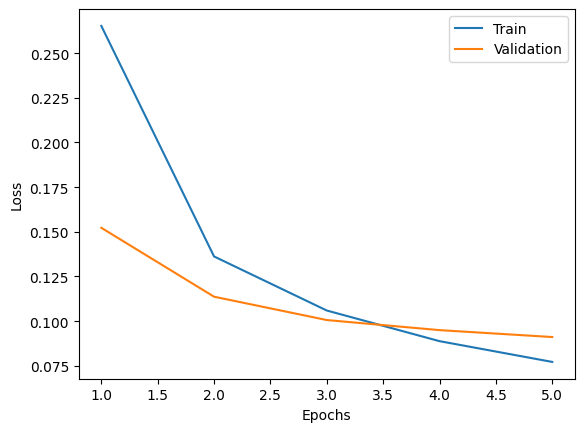

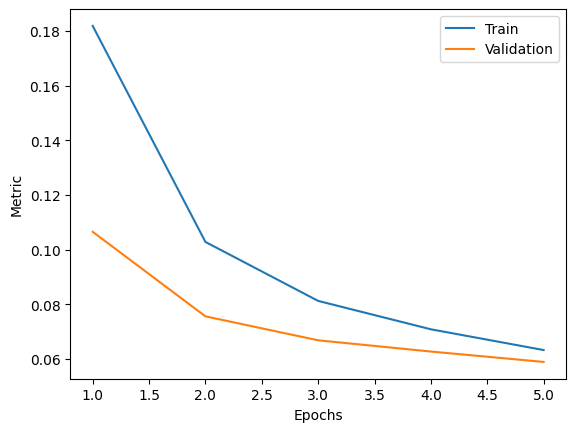

In [ ]:
plot_history(train_losses, train_hamming, valid_losses, valid_hamming)

# <font color = 'orange'>**Training Analysis**</font>

- Based on the results from the epoch outputs and the plots above, we can see that the **<font color='orange'>training loss</font>** is steadily decreasing across epochs, which indicates that the model is **<font color='orange'>learning</font>** and improving its predictions.
- From the **<font color='orange'>loss plot</font>**, the **<font color='orange'>validation loss</font>** remains consistently low and follows a similar pattern to the **<font color='orange'>training loss</font>**. This suggests that the model is **<font color='orange'>generalizing well</font>** on unseen data, which is a key sign of a good model.
- At this point, there are no signs of **<font color='orange'>overfitting</font>**, based on the number of epochs currently used. It could be valuable to increase the number of epochs in the future to **<font color='orange'>fine-tune</font>** the model and observe if the **<font color='orange'>validation loss</font>** starts increasing while the **<font color='orange'>training loss</font>** continues to decrease.
- The **<font color='orange'>hamming loss</font>** metric is also decreasing for both training and validation, which is a positive sign. The **<font color='orange'>hamming distance</font>** should decrease as training progresses because it measures how many predictions are **<font color='orange'>incorrect</font>** out of the total possible predictions.
- With these results, we can now proceed to **<font color='orange'>model evaluation</font>** on the testing dataset.



**Checkpoint**

In [ ]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/stack/2024-09-29_01-13-30_twolayer.pt')

In [ ]:
# Save the model's state dictionary to the specified file path
torch.save(model_stack.state_dict(), path)


In [ ]:

def get_hamming_distance_pred(data_loader, model, device):
    """
    Function to get predictions and Hamming distance for a given dataset using a trained model.
    Input: data iterator, model, device
    Output: predictions, actual labels, and Hamming distance for the given dataset.
    """
    model = model.to(device)
    model.eval()  # Set model to evaluation mode

    # Initialize empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Hamming distance metric (adjust num_labels to match your model's output size)
    hamming_metric = HammingDistance(task='multilabel', num_labels=NUM_OUTPUTS).to(device)

    running_hamming_distance = 0.0

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over batches from data loader
        for inputs, targets in data_loader:  # The missing loop
            # Move inputs and targets to the device
            inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
            targets = targets.to(device)

            # Forward pass: get model predictions
            outputs = model(inputs)

            # Apply threshold to convert outputs to binary predictions (e.g., 0.5 threshold)
            predicted = (outputs > 0.5).float()

            # Concatenate predictions and targets for the full dataset
            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets))

            # Compute Hamming distance for the current batch
            batch_hamming_distance = hamming_metric(predicted, targets).item()
            running_hamming_distance += batch_hamming_distance

    # Calculate average Hamming distance for the entire dataset
    avg_hamming_distance = running_hamming_distance / len(data_loader)

    return predictions, y, avg_hamming_distance


In [ ]:
predictions_valid, labels_valid, avg_hamming_distance = get_hamming_distance_pred(valid_loader, model_stack, device)
print(f"Average Hamming Distance on validation set: {avg_hamming_distance:.4f}")


Average Hamming Distance on validation set: 0.0587


In [ ]:
predictions_valid.shape

torch.Size([7589, 10])

In [ ]:
labels_valid.shape

torch.Size([7589, 10])

In [ ]:
def plot_multilabel_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots multiple confusion matrices for each label in a multilabel classification task.

    Args:
        valid_labels (torch.Tensor): True labels of the validation data.
        valid_preds (torch.Tensor): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    num_classes = len(class_labels)

    # Create a 10x10 grid for confusion matrices
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust for 10 classes

    for i, ax in enumerate(axes.flat):
        if i >= num_classes:
            break

        # Compute the confusion matrix for the current class
        cm = confusion_matrix(valid_labels[:, i].cpu(), valid_preds[:, i].cpu())

        # Plot the confusion matrix using Seaborn
        sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", ax=ax, cbar=True)

        # Set labels and title for each subplot
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix for {class_labels[i]}')

    plt.tight_layout()
    plt.show()

Average Hamming Distance on validation set: 0.0588


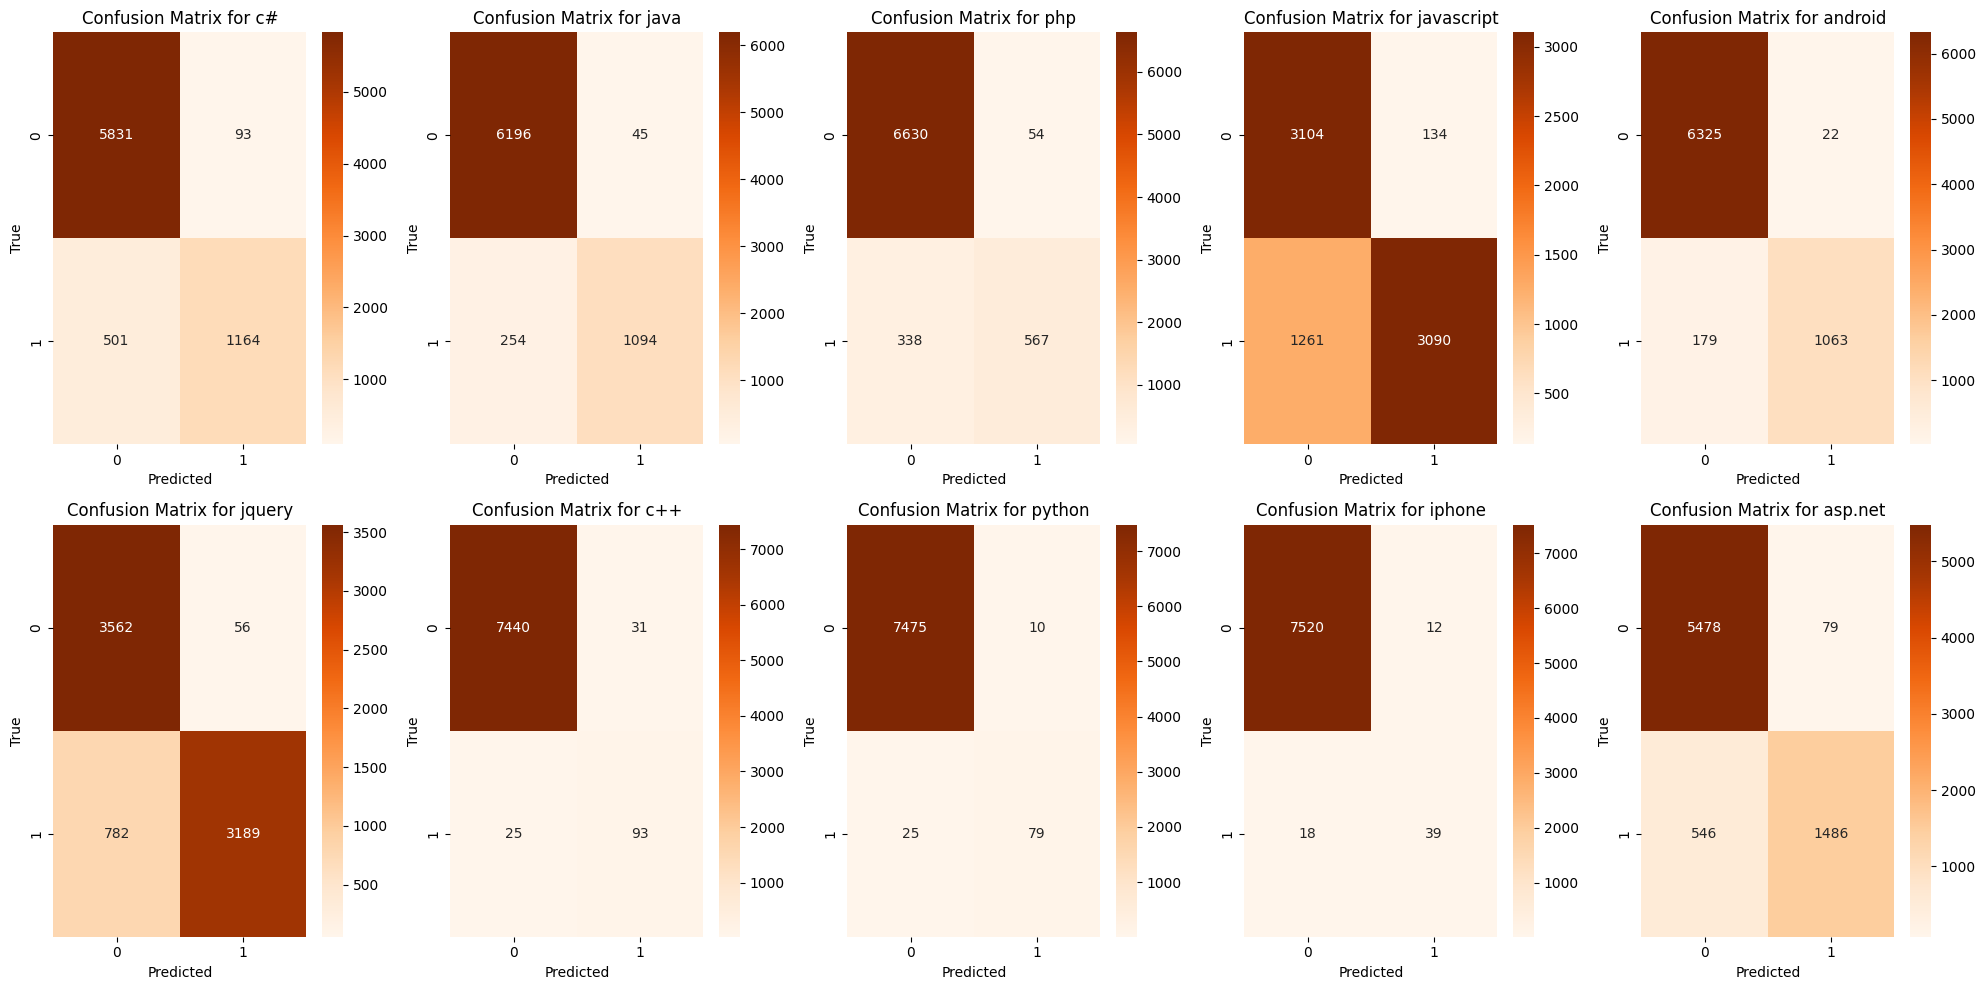

In [ ]:
# First, get the predictions and actual labels
predictions, y_true, avg_hamming_distance = get_hamming_distance_pred(valid_loader, model_stack, device)

print(f"Average Hamming Distance on validation set: {avg_hamming_distance:.4f}")

class_labels = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']


# Plot the confusion matrices
plot_multilabel_confusion_matrix(y_true, predictions, class_labels)


<

| **Label**     | **True Negative (%)** | **False Positive (%)** | **True Positive (%)** | **False Negative (%)** |
|---------------|-----------------------|------------------------|-----------------------|------------------------|
| **C#**        | 92.0%                 | 1.5%                   | 69.9%                 | 30.1%                  |
| **Java**      | 96.1%                 | 0.7%                   | 81.2%                 | 18.8%                  |
| **PHP**       | 98.1%                 | 0.8%                   | 62.7%                 | 37.3%                  |
| **JavaScript**| 71.0%                 | 3.1%                   | 71.0%                 | 29.0%                  |
| **Android**   | 99.7%                 | 0.3%                   | 85.6%                 | 14.4%                  |
| **jQuery**    | 97.7%                 | 1.5%                   | 80.3%                 | 19.7%                  |
| **C++**       | 99.6%                 | 0.4%                   | 78.8%                 | 21.2%                  |
| **Python**    | 99.9%                 | 0.1%                   | 75.9%                 | 24.1%                  |
| **iPhone**    | 99.8%                 | 0.2%                   | 68.4%                 | 31.6%                  |
| **ASP.NET**   | 98.6%                 | 1.4%                   | 73.1%                 | 26.9%                  |

### Simplified Summary:
- **True Negative**: The percent of times the model correctly said that a particular tag (like C# or Python) doesn't apply when it really doesn’t.
- **False Positive**: This is when the model incorrectly predicted a tag should be there when it was not there.
- **True Positive**: This is how often the model correctly predicted the tag was there for the code when it was.
- **False Negative**: This is when the model missed a tag when it should have been caught.

- **Java** and **Android** performed the best (over 80% predictions were correct.)
- **JavaScript** and **PHP** had slightly lower accuracy in predicting their respective tags.
- **Python** and **C++** were excellent at correctly identifying when their tags **shouldn’t** be there, making very few mistakes.




# <font color = 'orange'>**Model Testing**


In [ ]:
trained_model_stack = CustomMLP(vocab_size = VOCAB_SIZE,
                        embedding_dim = EMBED_DIM,
                        hidden_dim1 = HIDDEN_DIM1,
                        hidden_dim2 = HIDDEN_DIM2,
                        drop_prob1 = DROP_PROB1,
                        drop_prob2 = DROP_PROB2,
                        num_outputs = NUM_OUTPUTS)

checkpoint = torch.load(path) # saving the model to a file and passing the weights to the checkpoint to make predictions.
trained_model_stack.load_state_dict(checkpoint)

<ipython-input-83-146984b05a38>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path) # saving the model to a file and passing the weights to the ch

<All keys matched successfully>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred, class_labels):
    """
    Computes precision, recall, and F1 score for each class in a multilabel classification task.

    Args:
    - y_true: Ground truth labels (multilabel format).
    - y_pred: Predicted labels (multilabel format).
    - class_labels: List of class names.

    Returns:
    - result_table: A list of lists containing precision, recall, and F1 score for each class.
    """
    result_table = []

    for i, class_label in enumerate(class_labels):
        # Get true values and predicted values for the current class
        true_class = y_true[:, i].cpu().numpy()
        pred_class = y_pred[:, i].cpu().numpy()

        # Compute precision, recall, and F1 score
        precision = precision_score(true_class, pred_class, zero_division=1)
        recall = recall_score(true_class, pred_class, zero_division=1)
        f1 = f1_score(true_class, pred_class, zero_division=1)

        # Append the results for the current class
        result_table.append([class_label, precision, recall, f1])

    return result_table

# Example usage (after running your model and getting predictions)
class_labels = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']

# Assuming y_true and y_pred contain your true labels and predicted labels as tensors
result_table = compute_metrics(y_true, predictions, class_labels)

# Print the table
import pandas as pd
df = pd.DataFrame(result_table, columns=["Class", "Precision", "Recall", "F1 Score"])
print(df)


Average Hamming Distance on testing set: 0.0583


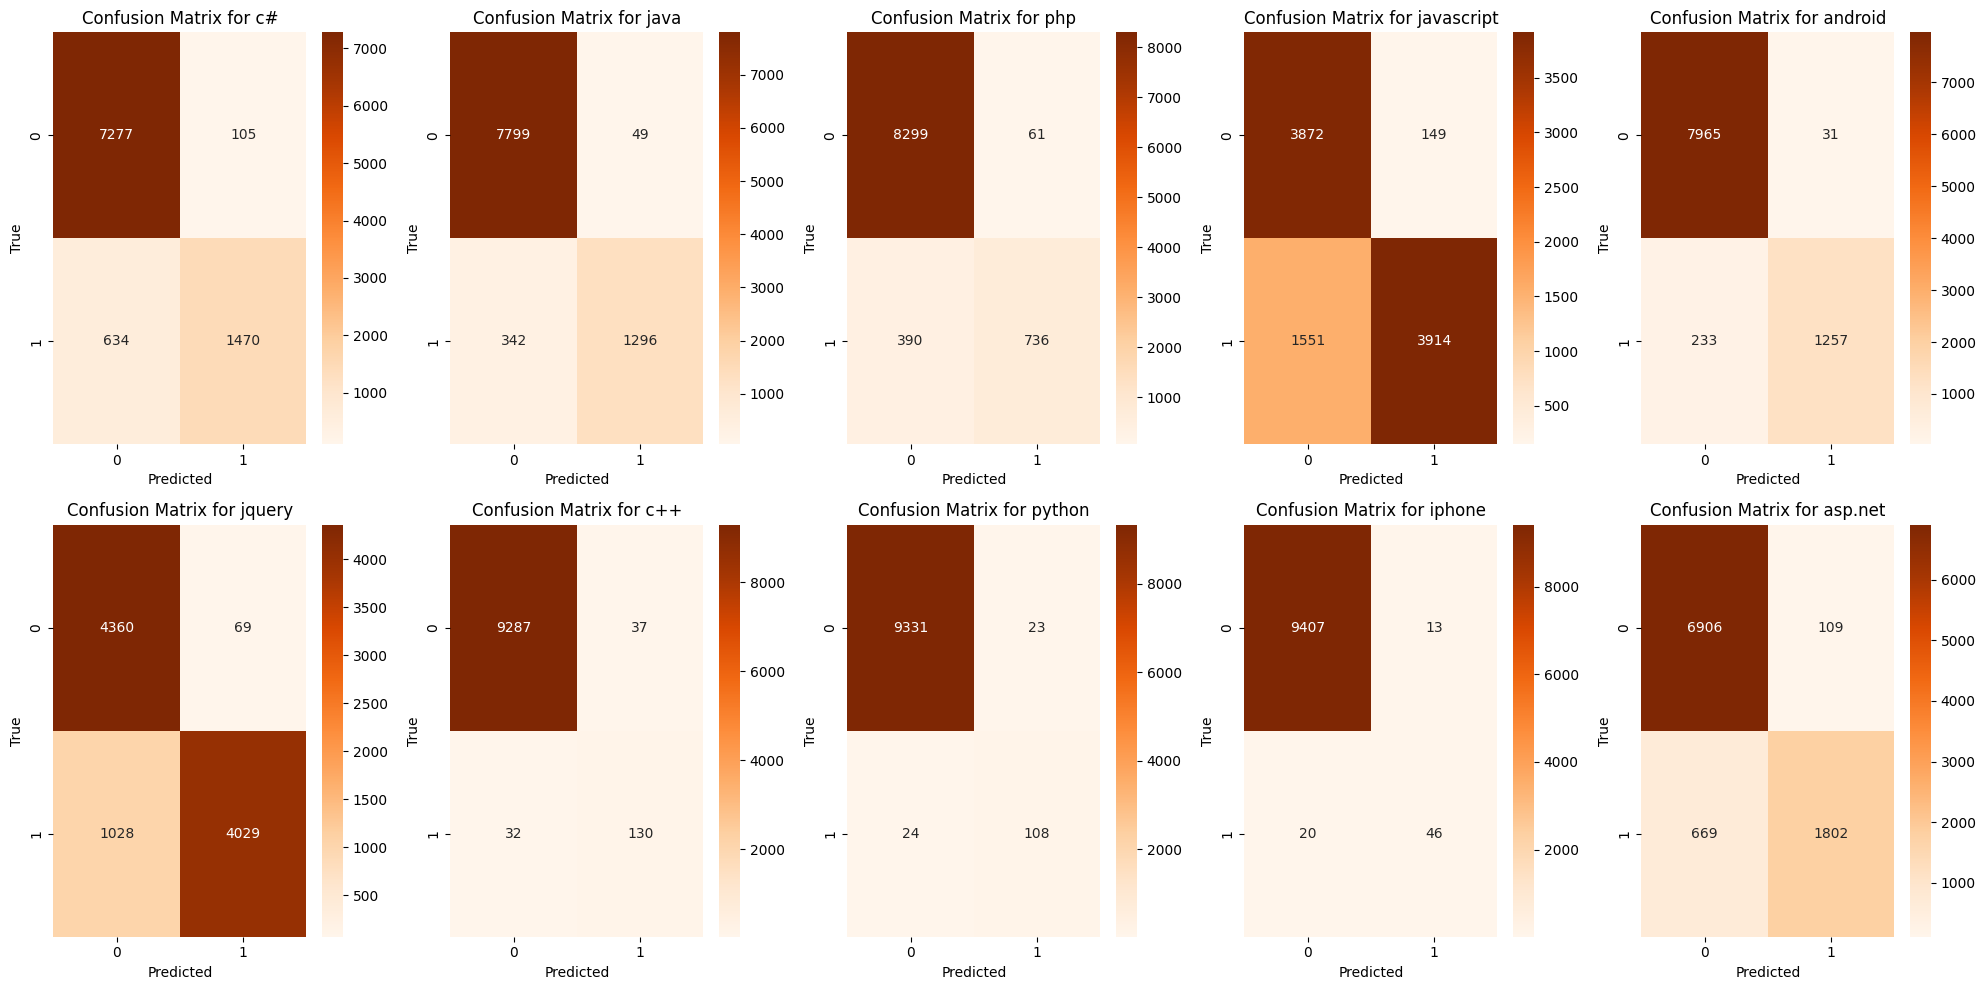

        Class  Precision    Recall  F1 Score
0          c#   0.933333  0.698669  0.799130
1        java   0.963569  0.791209  0.868924
2         php   0.923463  0.653641  0.765471
3  javascript   0.963328  0.716194  0.821579
4     android   0.975932  0.843624  0.904968
5      jquery   0.983163  0.796717  0.880175
6         c++   0.778443  0.802469  0.790274
7      python   0.824427  0.818182  0.821293
8      iphone   0.779661  0.696970  0.736000
9     asp.net   0.942962  0.729259  0.822455


In [ ]:
# Getting the predicitions
predictions_test, labels_test, avg_test_hamming_distance = get_hamming_distance_pred(test_loader, trained_model_stack, device)

# Printing the hamming distance
print(f"Average Hamming Distance on testing set: {avg_test_hamming_distance:.4f}")

# Plot the confusion matrices
plot_multilabel_confusion_matrix(labels_test, predictions_test, class_labels)
# Assuming y_true and y_pred contain your true labels and predicted labels as tensors
result_table = compute_metrics(labels_test, predictions_test, class_labels)

# Print the table
import pandas as pd
df = pd.DataFrame(result_table, columns=["Class", "Precision", "Recall", "F1 Score"])
print(df)


###  <font color = 'orange'>**Hamming Distance:**
- The **average Hamming distance** on the testing set was only 5.85%. This is around the same as for the validation and training set. This means that the model only incorrectly predicted 5.85% of all the labels.

### <font color = 'orange'>**Precision, Recall and F1**
- These metrics are there just for reference among the different labels.
- We can see how the best performing label is the android label followed by jquery and java.


# <font color = 'orange'>**Inference Pipeline**</font>

This is how the inference pipeline works:

**1. Preprocessing**: We’ll follow the same steps used during training:
  1. Convert the text into a list of indices using the vocab we created earlier.
  2. Concatenate all the text indices into a single tensor.
  3. Compute the offsets.

**2. Getting Predictions**:
  1. Move the model to the appropriate device (CPU or GPU).
  2. Put the model in evaluation mode.
  3. Pass the indices and offsets through the model to get the predictions (logits).

**3. Post-processing**:
  1. Convert the logits into class labels.
  2. Map those class labels back to their respective class names.


In [ ]:
sample_X = X_test[0:5]

In [ ]:
# Preprocessing the input
sample_X = X_test[0:5]
device = 'cpu'

list_of_list_of_indices = [tokenizer(text, stack_vocab) for text in sample_X]

# Compute the offsets for each text in the concatenated tensor
offsets = [0] + [len(i) for i in list_of_list_of_indices]
offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

# Concatenate all text indices into a single tensor
indices = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

# Move model to the appropriate device
trained_model_stack.to(device)

# Put model in evaluation mode
trained_model_stack.eval()

# Get outputs (logits) from the model
with torch.no_grad():
    outputs = trained_model_stack((indices, offsets))

# For multilabel classification, apply a threshold to determine class labels
predictions = (outputs > 0.5).float()  # Convert logits to binary predictions

# Define the mapping for class labels
class_labels = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']

# Get predicted labels for each sample
predicted_label_names = []
for sample_pred in predictions:
    predicted_classes = [class_labels[i] for i in range(len(class_labels)) if sample_pred[i] == 1]
    predicted_label_names.append(predicted_classes)

# Print the predicted labels for each sample
for i, label_names in enumerate(predicted_label_names):
    print(f"Sample {i+1}: {label_names}")


Sample 1: ['javascript', 'jquery']
Sample 2: ['c#', 'asp.net']
Sample 3: ['java']
Sample 4: ['c++']
Sample 5: ['javascript', 'jquery']
